# Classification Training Pipeline

This notebook implements a complete Graph Neural Network (GNN) pipeline for a 3-class classification task (`Low`, `Medium`, `High`).  It now includes additional metrics in hyperparameter tuning and enhanced model comparison visualizations.

## Table of Contents
1. [Environment & Setup](#step1)
2. [Model Definition](#step2)
3. [Evaluation Function](#step3)
4. [Hyperparameter Sweep (10-Fold CV)](#step4)
5. [Retraining & Validation (10-Fold CV)](#step5)
6. [Cross-Validation Results Visualization](#step6)
7. [Ensemble Averaging](#step7)
8. [Final Model Training & Test Evaluation](#step8)
9. [Baseline QSAR Comparison](#step9)

---

## Prerequisites
- PyTorch & PyTorch Geometric  
- scikit-learn  
- pandas, numpy, matplotlib  
- RDKit (only for feature extraction)  
- GPU recommended

Install requirements:
```bash
pip install torch torch-geometric scikit-learn pandas numpy matplotlib rdkit-pypi
```

---

<a id="step1"></a>
## Step 1: Environment & Setup
- Seed all random generators for reproducibility.  
- Define paths for data splits and output.  
- Detect GPU/CPU.

<a id="step2"></a>
## Step 2: Model Definition
Defines:
- `edgeGCN` Taking into account edge features  
- `DeepGNNWithEdgeFeatures`: GCN with GraphSAGE, incorporating edge features, global mean pool, and final linear head.

<a id="step3"></a>
## Step 3: Evaluation Function
`evaluate(model, loader)` returns concatenated logits and true labels.

<a id="step4"></a>
## Step 4: Hyperparameter Sweep (10-Fold CV)
**Updates:** Now tracks both **AUC-ROC** and **Balanced Accuracy** per fold.

- Grid search over `hidden_channels`, `dropout`, `lr`.  
- For each config, run 10-fold CV: train for 50 epochs, then evaluate validation set.
- Compute per-fold metrics:
  - **AUC-ROC** (one-vs-rest)
  - **Balanced Accuracy** (accounts for class imbalance)
- Record **mean ± std** for both metrics.
- Results DataFrame `sweep_df` now contains `mean_auc`, `std_auc`, `mean_balanced_acc`, and `std_balanced_acc`.

<a id="step5"></a>
## Step 5: Retraining & Validation (10-Fold CV)
- Retrain each fold with best hyperparameters and early stopping.  
- Save best model weights.  
- Compute per-fold classification metrics: accuracy, precision, recall, F1, AUC-ROC.  
- Save `crossval_summary.csv`.

<a id="step6"></a>
## Step 6: Cross-Validation Results Visualization
- Load `crossval_summary.csv`.  
- Plot bar charts for each metric across folds.  
- Print mean ± std.

<a id="step7"></a>
## Step 7: Ensemble Averaging
- Load fold checkpoints, run on test set, average logits.  
- Save `ensemble_preds.csv` (True vs. Pred).
- **Ensemble evaluation plots** include confusion matrix and per-class ROC curves.

<a id="step8"></a>
## Step 8: Final Model Training & Test Evaluation
- Merge all train+val folds, reserve 10% for validation.  
- Train final model with early stopping and LR scheduler.  
- Evaluate on hold-out test: accuracy, precision, recall, F1, AUC-ROC.
- Plot confusion matrix and per-class ROC curves.  
- Save `final_model_metrics.csv`, `final_confusion_matrix.png`, and `final_auc_roc.png`.


---

## Parameters & Extensions
- **Epochs:** 50 for CV, 100 for final training  
- **Patience:** 10 for early stopping  
- **LR Scheduler:** `ReduceLROnPlateau` on validation loss  





## 1. Imports and Setup

In [13]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import random

## 2. Task and Reproducibility Setup

In [20]:
# Set seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark     = False

# DataLoader seeding
from torch.utils.data import DataLoader as _DL
from torch.utils.data import get_worker_info

def seed_worker(worker_id):
    worker_seed = seed + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(seed)

# task = "classification"  # or "regression"
task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}
kfold = 10
base_path = f"../4_train_test_split/10fold_cv/{task}/"
results_dir = f"GraphSAGE_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

## 3b. Define GraphSAGE Layer and GraphSAGE Model

In [21]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch.nn import LayerNorm

class EdgeGNNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_channels, mlp_depth=2):
        """
        Args:
            in_channels (int): Dimension of node features coming in.
            out_channels (int): Dimension of node features going out.
            edge_channels (int): Dimension of edge features.
            mlp_depth (int): Number of hidden layers in the MLPs (minimum 1).
        """
        super(EdgeGNNLayer, self).__init__(aggr='add')
        
        # Build a deeper node MLP: input dimension is (in_channels + edge_channels)
        node_mlp_layers = []
        input_dim = in_channels + edge_channels
        hidden_channels = out_channels  # could also set a different hidden dimension if needed
        for _ in range(mlp_depth - 1):
            node_mlp_layers.append(torch.nn.Linear(input_dim, hidden_channels))
            node_mlp_layers.append(torch.nn.ReLU())
            input_dim = hidden_channels
        node_mlp_layers.append(torch.nn.Linear(input_dim, out_channels))
        self.node_mlp = torch.nn.Sequential(*node_mlp_layers)
        
        # Build a deeper edge MLP for transforming edge features
        edge_mlp_layers = []
        input_dim_e = edge_channels
        hidden_channels_e = edge_channels  # preserving the original dimension
        for _ in range(mlp_depth - 1):
            edge_mlp_layers.append(torch.nn.Linear(input_dim_e, hidden_channels_e))
            edge_mlp_layers.append(torch.nn.ReLU())
            input_dim_e = hidden_channels_e
        edge_mlp_layers.append(torch.nn.Linear(input_dim_e, edge_channels))
        self.edge_mlp = torch.nn.Sequential(*edge_mlp_layers)

    def forward(self, x, edge_index, edge_attr):
        # Transform edge features through a deeper MLP
        edge_attr = self.edge_mlp(edge_attr)
        # Propagate messages
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # Concatenate neighboring node features with corresponding edge features
        return torch.cat([x_j, edge_attr], dim=1)

    def update(self, aggr_out):
        # Update node features after aggregation using the deeper MLP
        return self.node_mlp(aggr_out)

class DeepGNNWithEdgeFeatures(torch.nn.Module):
    def __init__(self, in_channels, edge_channels, hidden_channels, out_channels, num_layers=6, mlp_depth=3, dropout=0.5):
        """
        Args:
            in_channels (int): Dimension of initial node features.
            edge_channels (int): Dimension of edge features.
            hidden_channels (int): Dimension for hidden layers.
            out_channels (int): Dimension for output.
            num_layers (int): Number of message passing layers.
            mlp_depth (int): Depth of the MLPs inside each message passing layer.
            dropout (float): Dropout probability for the output MLP.
        """
        super(DeepGNNWithEdgeFeatures, self).__init__()
        self.lin_in = torch.nn.Linear(in_channels, hidden_channels)
        
        # Stack multiple message passing layers and norm layers.
        self.layers = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(EdgeGNNLayer(hidden_channels, hidden_channels, edge_channels, mlp_depth=mlp_depth))
            self.norms.append(LayerNorm(hidden_channels))
        
        # A deeper output MLP to further transform after pooling.
        self.lin_out = torch.nn.Sequential(
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_channels, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        
        # Initial feature transformation
        x = F.relu(self.lin_in(x))
        
        # Passing through deeper stack of message passing layers with residual connections
        for layer, norm in zip(self.layers, self.norms):
            x_res = x  # save for residual connection
            x = layer(x, edge_index, edge_attr)
            x = x + x_res  # add residual connection
            x = norm(x)
            x = F.relu(x)
        
        # Global pooling over nodes for each graph
        x = global_mean_pool(x, batch)
        
        # Final transformation for graph-level output
        return self.lin_out(x)


## 4. Evaluation Helper Function

In [22]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

## 5. Input Dimensions and Device Setup

In [23]:
sample_data = torch.load(os.path.join(base_path, f"{task}_train_fold0.pt"))[0]
input_dim = sample_data.x.size(1)
edge_dim = sample_data.edge_attr.size(1)
out_channels = num_classes if task == "classification" else 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\303463795.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_data = torch.load(os.path.join(base_path, f"{task}_tr

# ## Step 4: Select Best Hyperparameters
# Use this section to manually define the best hyperparameters based on the sweep above.


In [34]:
# Hyperparameter grids
hidden_dims = [64, 128, 256]
dropouts = [0.0, 0.2, 0.4]
lrs = [1e-3, 5e-4, 1e-4]

results = []
print("Starting hyperparameter sweep over hidden_dim, dropout, and learning rate")
for hd in hidden_dims:
    for dp in dropouts:
        for lr in lrs:
            print(f"Config: hidden_dim={hd}, dropout={dp}, lr={lr}")
            fold_metrics = []
            for fold in range(10):
                # Load fold data
                train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
                val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

                # Initialize model and optimizer
                model = DeepGNNWithEdgeFeatures(input_dim, edge_dim,
                             hidden_channels=hd,
                             out_channels=out_channels,
                             dropout=dp).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Data loaders
                train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
                val_loader   = DataLoader(val_data,   batch_size=32)

                # Training loop
                for epoch in range(1, 51):
                    model.train()
                    for batch in train_loader:
                        batch = batch.to(device)
                        optimizer.zero_grad()
                        out = model(batch)
                        loss = F.mse_loss(out.squeeze(), batch.y)
                        loss.backward()
                        optimizer.step()

                # Validation
                preds, trues = evaluate(model, val_loader)
                y_true = trues.numpy()
                y_pred = preds.squeeze().numpy()
                r2 = r2_score(y_true, y_pred)
                fold_metrics.append(r2)

            # Record mean and std
            mean_r2 = np.mean(fold_metrics)
            std_r2  = np.std(fold_metrics)
            results.append((hd, dp, lr, mean_r2, std_r2))
            print(f"📊 R²: {mean_r2:.4f} ± {std_r2:.4f}")

# Compile results into DataFrame
sweep_df = pd.DataFrame(results,
                        columns=["hidden_dim", "dropout", "learning_rate", "mean_r2", "std_r2"])
# Display sorted by best performance
display(sweep_df.sort_values("mean_r2", ascending=False))
cv_df = pd.DataFrame(fold_metrics)


Starting hyperparameter sweep over hidden_dim, dropout, and learning rate
Config: hidden_dim=64, dropout=0.0, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2443 ± 0.1507
Config: hidden_dim=64, dropout=0.0, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2154 ± 0.1743
Config: hidden_dim=64, dropout=0.0, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: -0.0743 ± 0.1604
Config: hidden_dim=64, dropout=0.2, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2527 ± 0.1279
Config: hidden_dim=64, dropout=0.2, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.1529 ± 0.2558
Config: hidden_dim=64, dropout=0.2, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: -0.0899 ± 0.2164
Config: hidden_dim=64, dropout=0.4, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.1773 ± 0.2464
Config: hidden_dim=64, dropout=0.4, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.0808 ± 0.1976
Config: hidden_dim=64, dropout=0.4, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: -0.1401 ± 0.2960
Config: hidden_dim=128, dropout=0.0, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2323 ± 0.2360
Config: hidden_dim=128, dropout=0.0, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2512 ± 0.1918
Config: hidden_dim=128, dropout=0.0, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.0371 ± 0.2387
Config: hidden_dim=128, dropout=0.2, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.0292 ± 0.3964
Config: hidden_dim=128, dropout=0.2, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2361 ± 0.1676
Config: hidden_dim=128, dropout=0.2, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: -0.0146 ± 0.1718
Config: hidden_dim=128, dropout=0.4, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.1299 ± 0.3446
Config: hidden_dim=128, dropout=0.4, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2248 ± 0.0719
Config: hidden_dim=128, dropout=0.4, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: -0.1418 ± 0.3074
Config: hidden_dim=256, dropout=0.0, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2002 ± 0.2477
Config: hidden_dim=256, dropout=0.0, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2090 ± 0.2683
Config: hidden_dim=256, dropout=0.0, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.1807 ± 0.1837
Config: hidden_dim=256, dropout=0.2, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2116 ± 0.2347
Config: hidden_dim=256, dropout=0.2, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.1742 ± 0.4028
Config: hidden_dim=256, dropout=0.2, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.1838 ± 0.1365
Config: hidden_dim=256, dropout=0.4, lr=0.001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.2133 ± 0.1707
Config: hidden_dim=256, dropout=0.4, lr=0.0005


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.1655 ± 0.2201
Config: hidden_dim=256, dropout=0.4, lr=0.0001


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2640689684.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

📊 R²: 0.1396 ± 0.1851


,hidden_dim,dropout,learning_rate,mean_r2,std_r2
3,64,0.2,0.0010,0.252680,0.127880
10,128,0.0,0.0005,0.251198,0.191826
0,64,0.0,0.0010,0.244348,0.150749
13,128,0.2,0.0005,0.236129,0.167576
9,128,0.0,0.0010,0.232271,0.236020
16,128,0.4,0.0005,0.224789,0.071870
1,64,0.0,0.0005,0.215442,0.174269
24,256,0.4,0.0010,0.213348,0.170670
21,256,0.2,0.0010,0.211639,0.234659
19,256,0.0,0.0005,0.209035,0.268278


In [40]:
# Load the best model configuration
best_hidden_dim = 64
best_dropout = 0.2
best_lr = 0.001
print(f"Best config: hidden_channels={best_hidden_channels}, dropout={best_dropout}, lr={best_lr}")

Best config: hidden_channels=64, dropout=0.2, lr=0.001


# ## Step 5a: Retrain All Folds with Best Hyperparameters

In [42]:

# %%
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import pandas as pd

fold_metrics = []

for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10 with best hyperparameters")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = DeepGNNWithEdgeFeatures(input_dim, edge_dim,
                 hidden_channels=best_hidden_dim,
                 out_channels=out_channels,
                 dropout=best_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf')
    patience = 0

    # Training loop with early stopping
    for epoch in range(1, 301):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = (F.cross_entropy(out, batch.y.long())
                    if task=="classification"
                    else F.mse_loss(out.squeeze(), batch.y))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate on validation
        preds, targets = evaluate(model, val_loader)
        val_loss = (F.cross_entropy(preds, targets.long()).item()
                    if task=="classification"
                    else F.mse_loss(preds.squeeze(), targets).item())

        print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
            torch.save(model.state_dict(),
                       os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience += 1
            if patience >= 10:
                print("⏹️ Early stopping")
                break

    # --- After training this fold, compute metrics on its validation set ---
    preds_np = preds.squeeze().cpu().numpy()
    trues_np = targets.cpu().numpy()

    if task == "classification":
        from sklearn.metrics import (
            accuracy_score,
            precision_recall_fscore_support,
            roc_auc_score
        )
        y_true = trues_np.astype(int)
        y_probs = F.softmax(preds, dim=1).cpu().numpy()
        y_pred  = preds.argmax(dim=1).cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted", zero_division=0)
        auc = roc_auc_score(
            label_binarize(y_true, classes=np.arange(num_classes)),
            y_probs, multi_class="ovr")

        fold_metrics.append({
            "fold": fold+1,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc_roc": auc
        })
    else:  # regression
        mae  = mean_absolute_error(trues_np, preds_np)
        mse  = mean_squared_error(trues_np, preds_np)
        rmse = np.sqrt(mse)
        r2   = r2_score(trues_np, preds_np)

        fold_metrics.append({
            "fold": fold+1,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "r2": r2
        })

# --- Save the cross-validation summary ---
cv_df = pd.DataFrame(fold_metrics)
cv_path = os.path.join(results_dir, "crossval_summary.csv")
cv_df.to_csv(cv_path, index=False)
print(f"✅ Saved cross‑validation summary to {cv_path}")



🔁 Retraining Fold 1/10 with best hyperparameters


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2333233398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

Epoch 001 | Train Loss: 43.3222 | Val Loss: 33.7825
Epoch 002 | Train Loss: 29.1427 | Val Loss: 15.0910
Epoch 003 | Train Loss: 8.1760 | Val Loss: 1.3934
Epoch 004 | Train Loss: 3.1176 | Val Loss: 1.3282
Epoch 005 | Train Loss: 2.4329 | Val Loss: 1.4389
Epoch 006 | Train Loss: 2.3359 | Val Loss: 1.2646
Epoch 007 | Train Loss: 2.4706 | Val Loss: 1.4479
Epoch 008 | Train Loss: 2.3238 | Val Loss: 1.2690
Epoch 009 | Train Loss: 2.3291 | Val Loss: 1.2749
Epoch 010 | Train Loss: 2.4276 | Val Loss: 1.4745
Epoch 011 | Train Loss: 2.2443 | Val Loss: 1.3931
Epoch 012 | Train Loss: 2.2589 | Val Loss: 1.3319
Epoch 013 | Train Loss: 2.3745 | Val Loss: 1.3393
Epoch 014 | Train Loss: 2.3341 | Val Loss: 1.3755
Epoch 015 | Train Loss: 2.2706 | Val Loss: 1.2561
Epoch 016 | Train Loss: 1.9685 | Val Loss: 1.2647
Epoch 017 | Train Loss: 2.2071 | Val Loss: 1.3910
Epoch 018 | Train Loss: 2.1075 | Val Loss: 1.2564
Epoch 019 | Train Loss: 2.0639 | Val Loss: 1.3082
Epoch 020 | Train Loss: 2.1579 | Val Loss: 1.2

C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2333233398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

Epoch 001 | Train Loss: 43.0237 | Val Loss: 32.3753
Epoch 002 | Train Loss: 24.9294 | Val Loss: 11.5469
Epoch 003 | Train Loss: 5.6871 | Val Loss: 1.8611
Epoch 004 | Train Loss: 2.7756 | Val Loss: 1.3736
Epoch 005 | Train Loss: 2.4073 | Val Loss: 1.2724
Epoch 006 | Train Loss: 2.3590 | Val Loss: 1.2578
Epoch 007 | Train Loss: 2.2809 | Val Loss: 1.2603
Epoch 008 | Train Loss: 2.1899 | Val Loss: 1.2473
Epoch 009 | Train Loss: 2.1250 | Val Loss: 1.2606
Epoch 010 | Train Loss: 2.2286 | Val Loss: 1.2498
Epoch 011 | Train Loss: 2.1736 | Val Loss: 1.2563
Epoch 012 | Train Loss: 2.1345 | Val Loss: 1.2424
Epoch 013 | Train Loss: 2.1281 | Val Loss: 1.3067
Epoch 014 | Train Loss: 2.4514 | Val Loss: 1.2372
Epoch 015 | Train Loss: 2.2797 | Val Loss: 1.2452
Epoch 016 | Train Loss: 2.1858 | Val Loss: 1.6285
Epoch 017 | Train Loss: 2.3001 | Val Loss: 1.3559
Epoch 018 | Train Loss: 2.2014 | Val Loss: 1.2383
Epoch 019 | Train Loss: 2.0365 | Val Loss: 1.2432
Epoch 020 | Train Loss: 2.0818 | Val Loss: 1.2

C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2333233398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

Epoch 001 | Train Loss: 40.1648 | Val Loss: 38.4585
Epoch 002 | Train Loss: 20.2910 | Val Loss: 10.8431
Epoch 003 | Train Loss: 3.9919 | Val Loss: 1.0435
Epoch 004 | Train Loss: 2.5846 | Val Loss: 2.5162
Epoch 005 | Train Loss: 2.1485 | Val Loss: 1.2894
Epoch 006 | Train Loss: 2.1946 | Val Loss: 1.5854
Epoch 007 | Train Loss: 2.1367 | Val Loss: 1.9232
Epoch 008 | Train Loss: 1.9611 | Val Loss: 1.4243
Epoch 009 | Train Loss: 2.1266 | Val Loss: 1.5026
Epoch 010 | Train Loss: 1.8918 | Val Loss: 1.7186
Epoch 011 | Train Loss: 2.1556 | Val Loss: 2.2272
Epoch 012 | Train Loss: 2.1244 | Val Loss: 1.4290
Epoch 013 | Train Loss: 2.0425 | Val Loss: 1.4887
⏹️ Early stopping

🔁 Retraining Fold 4/10 with best hyperparameters


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2333233398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

Epoch 001 | Train Loss: 42.7258 | Val Loss: 36.6334
Epoch 002 | Train Loss: 26.9526 | Val Loss: 15.3747
Epoch 003 | Train Loss: 6.9846 | Val Loss: 1.2560
Epoch 004 | Train Loss: 2.6728 | Val Loss: 1.7162
Epoch 005 | Train Loss: 2.5348 | Val Loss: 1.2590
Epoch 006 | Train Loss: 2.1135 | Val Loss: 1.1684
Epoch 007 | Train Loss: 2.3510 | Val Loss: 1.3681
Epoch 008 | Train Loss: 2.1086 | Val Loss: 1.1894
Epoch 009 | Train Loss: 2.5342 | Val Loss: 1.2964
Epoch 010 | Train Loss: 2.2108 | Val Loss: 1.2680
Epoch 011 | Train Loss: 2.1729 | Val Loss: 1.2492
Epoch 012 | Train Loss: 1.9241 | Val Loss: 1.1651
Epoch 013 | Train Loss: 1.9468 | Val Loss: 1.2058
Epoch 014 | Train Loss: 2.1559 | Val Loss: 1.1848
Epoch 015 | Train Loss: 2.2708 | Val Loss: 1.1714
Epoch 016 | Train Loss: 2.2077 | Val Loss: 1.1921
Epoch 017 | Train Loss: 2.0118 | Val Loss: 1.1845
Epoch 018 | Train Loss: 2.0053 | Val Loss: 1.2018
Epoch 019 | Train Loss: 2.0973 | Val Loss: 1.1446
Epoch 020 | Train Loss: 2.1466 | Val Loss: 1.2

C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2333233398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

Epoch 001 | Train Loss: 44.7413 | Val Loss: 35.9515
Epoch 002 | Train Loss: 30.6249 | Val Loss: 19.6838
Epoch 003 | Train Loss: 12.4549 | Val Loss: 2.2562
Epoch 004 | Train Loss: 3.0429 | Val Loss: 2.1107
Epoch 005 | Train Loss: 2.5625 | Val Loss: 1.3251
Epoch 006 | Train Loss: 2.3325 | Val Loss: 1.2702
Epoch 007 | Train Loss: 2.7525 | Val Loss: 1.2885
Epoch 008 | Train Loss: 2.4155 | Val Loss: 1.2563
Epoch 009 | Train Loss: 2.4302 | Val Loss: 1.2951
Epoch 010 | Train Loss: 2.2811 | Val Loss: 1.2411
Epoch 011 | Train Loss: 2.2555 | Val Loss: 1.2242
Epoch 012 | Train Loss: 2.3335 | Val Loss: 1.2163
Epoch 013 | Train Loss: 2.2833 | Val Loss: 1.1976
Epoch 014 | Train Loss: 2.5427 | Val Loss: 1.2096
Epoch 015 | Train Loss: 2.3327 | Val Loss: 1.1992
Epoch 016 | Train Loss: 2.5171 | Val Loss: 1.1894
Epoch 017 | Train Loss: 2.0777 | Val Loss: 1.1069
Epoch 018 | Train Loss: 2.2032 | Val Loss: 0.9687
Epoch 019 | Train Loss: 2.1257 | Val Loss: 1.1991
Epoch 020 | Train Loss: 2.2418 | Val Loss: 0.

C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2333233398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

Epoch 001 | Train Loss: 42.9229 | Val Loss: 36.7261
Epoch 002 | Train Loss: 26.7762 | Val Loss: 14.7700
Epoch 003 | Train Loss: 6.3054 | Val Loss: 1.8322
Epoch 004 | Train Loss: 3.2535 | Val Loss: 1.6271
Epoch 005 | Train Loss: 2.3251 | Val Loss: 1.3241
Epoch 006 | Train Loss: 2.1236 | Val Loss: 1.4118
Epoch 007 | Train Loss: 2.1574 | Val Loss: 1.3249
Epoch 008 | Train Loss: 2.1205 | Val Loss: 1.3475
Epoch 009 | Train Loss: 2.1160 | Val Loss: 1.3538
Epoch 010 | Train Loss: 2.2204 | Val Loss: 1.3409
Epoch 011 | Train Loss: 2.0650 | Val Loss: 1.3242
Epoch 012 | Train Loss: 1.9141 | Val Loss: 1.3336
Epoch 013 | Train Loss: 1.9874 | Val Loss: 1.3379
Epoch 014 | Train Loss: 2.3502 | Val Loss: 1.4326
Epoch 015 | Train Loss: 1.9564 | Val Loss: 1.3225
Epoch 016 | Train Loss: 2.1449 | Val Loss: 1.3273
Epoch 017 | Train Loss: 2.1148 | Val Loss: 1.4538
Epoch 018 | Train Loss: 1.9347 | Val Loss: 1.4155
Epoch 019 | Train Loss: 1.8311 | Val Loss: 1.3374
Epoch 020 | Train Loss: 2.0739 | Val Loss: 1.3

C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2333233398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

Epoch 001 | Train Loss: 41.4162 | Val Loss: 31.1198
Epoch 002 | Train Loss: 20.4205 | Val Loss: 6.7183
Epoch 003 | Train Loss: 3.5276 | Val Loss: 2.8869
Epoch 004 | Train Loss: 2.6063 | Val Loss: 1.6033
Epoch 005 | Train Loss: 2.2586 | Val Loss: 1.4630
Epoch 006 | Train Loss: 2.2643 | Val Loss: 1.4664
Epoch 007 | Train Loss: 2.2182 | Val Loss: 1.4374
Epoch 008 | Train Loss: 2.1826 | Val Loss: 1.4552
Epoch 009 | Train Loss: 2.3148 | Val Loss: 1.4577
Epoch 010 | Train Loss: 2.2306 | Val Loss: 1.4624
Epoch 011 | Train Loss: 2.0525 | Val Loss: 1.4362
Epoch 012 | Train Loss: 2.2082 | Val Loss: 1.4331
Epoch 013 | Train Loss: 2.2420 | Val Loss: 1.5435
Epoch 014 | Train Loss: 2.0802 | Val Loss: 1.4530
Epoch 015 | Train Loss: 1.9869 | Val Loss: 1.4537
Epoch 016 | Train Loss: 1.9076 | Val Loss: 1.4232
Epoch 017 | Train Loss: 2.1045 | Val Loss: 1.4167
Epoch 018 | Train Loss: 1.9920 | Val Loss: 1.4313
Epoch 019 | Train Loss: 2.0089 | Val Loss: 1.4033
Epoch 020 | Train Loss: 1.7366 | Val Loss: 1.43

C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2333233398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

Epoch 001 | Train Loss: 43.3986 | Val Loss: 35.6666
Epoch 002 | Train Loss: 23.8437 | Val Loss: 10.2446
Epoch 003 | Train Loss: 4.5126 | Val Loss: 2.0655
Epoch 004 | Train Loss: 3.0677 | Val Loss: 1.7286
Epoch 005 | Train Loss: 2.5215 | Val Loss: 1.1114
Epoch 006 | Train Loss: 2.1406 | Val Loss: 1.1139
Epoch 007 | Train Loss: 2.0873 | Val Loss: 1.0701
Epoch 008 | Train Loss: 2.2985 | Val Loss: 1.1245
Epoch 009 | Train Loss: 2.1604 | Val Loss: 1.0889
Epoch 010 | Train Loss: 2.2549 | Val Loss: 1.0733
Epoch 011 | Train Loss: 2.4668 | Val Loss: 1.2209
Epoch 012 | Train Loss: 2.1780 | Val Loss: 1.1794
Epoch 013 | Train Loss: 2.3360 | Val Loss: 1.0686
Epoch 014 | Train Loss: 2.1935 | Val Loss: 1.0741
Epoch 015 | Train Loss: 2.3818 | Val Loss: 1.0827
Epoch 016 | Train Loss: 2.2347 | Val Loss: 1.2036
Epoch 017 | Train Loss: 2.3229 | Val Loss: 1.0760
Epoch 018 | Train Loss: 2.3125 | Val Loss: 1.2787
Epoch 019 | Train Loss: 2.1987 | Val Loss: 1.1076
Epoch 020 | Train Loss: 2.3024 | Val Loss: 1.1

C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2333233398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

Epoch 001 | Train Loss: 44.2743 | Val Loss: 33.4544
Epoch 002 | Train Loss: 28.5967 | Val Loss: 13.8487
Epoch 003 | Train Loss: 7.6709 | Val Loss: 1.5875
Epoch 004 | Train Loss: 3.3619 | Val Loss: 1.4452
Epoch 005 | Train Loss: 2.4341 | Val Loss: 1.3400
Epoch 006 | Train Loss: 2.4847 | Val Loss: 1.4489
Epoch 007 | Train Loss: 2.4075 | Val Loss: 1.3506
Epoch 008 | Train Loss: 2.5123 | Val Loss: 1.3441
Epoch 009 | Train Loss: 2.4587 | Val Loss: 1.4055
Epoch 010 | Train Loss: 2.2572 | Val Loss: 1.3509
Epoch 011 | Train Loss: 2.3244 | Val Loss: 1.3284
Epoch 012 | Train Loss: 2.0645 | Val Loss: 1.5612
Epoch 013 | Train Loss: 2.0761 | Val Loss: 1.3228
Epoch 014 | Train Loss: 2.1899 | Val Loss: 1.3291
Epoch 015 | Train Loss: 2.3418 | Val Loss: 1.3853
Epoch 016 | Train Loss: 2.3473 | Val Loss: 1.3360
Epoch 017 | Train Loss: 2.1412 | Val Loss: 1.4282
Epoch 018 | Train Loss: 2.1991 | Val Loss: 1.3181
Epoch 019 | Train Loss: 2.0907 | Val Loss: 1.3508
Epoch 020 | Train Loss: 2.3042 | Val Loss: 1.3

C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\2333233398.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_path, f"{task}_t

Epoch 001 | Train Loss: 42.2013 | Val Loss: 36.4628
Epoch 002 | Train Loss: 25.5946 | Val Loss: 15.6000
Epoch 003 | Train Loss: 7.0805 | Val Loss: 1.6653
Epoch 004 | Train Loss: 3.0891 | Val Loss: 1.9921
Epoch 005 | Train Loss: 2.3994 | Val Loss: 1.6890
Epoch 006 | Train Loss: 2.2544 | Val Loss: 1.7383
Epoch 007 | Train Loss: 2.0100 | Val Loss: 1.6848
Epoch 008 | Train Loss: 2.0809 | Val Loss: 1.6665
Epoch 009 | Train Loss: 2.2493 | Val Loss: 1.7563
Epoch 010 | Train Loss: 2.2743 | Val Loss: 1.7095
Epoch 011 | Train Loss: 2.0513 | Val Loss: 1.7041
Epoch 012 | Train Loss: 2.0967 | Val Loss: 1.7610
Epoch 013 | Train Loss: 2.0727 | Val Loss: 1.6942
⏹️ Early stopping
✅ Saved cross‑validation summary to GraphSAGE_results/regression_10fold/crossval_summary.csv


# ## Step 6: Visualize Cross-Validation Results


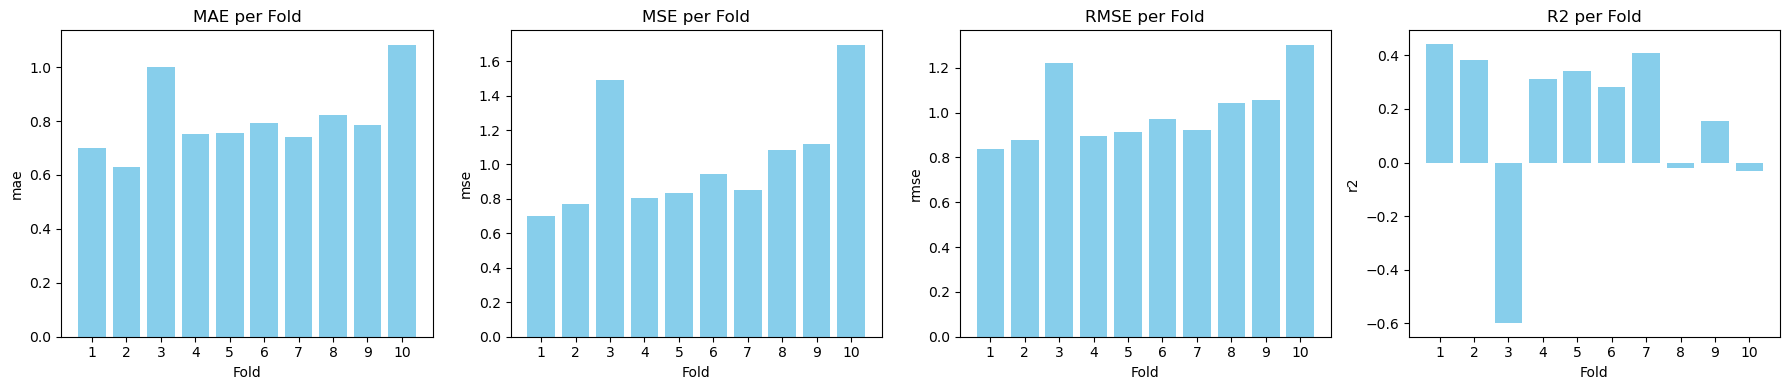

📊 Mean ± Std for Cross-Validation Metrics:


,mean,std
mae,0.8060,0.1360
mse,1.0290,0.3279
rmse,1.0040,0.1531
r2,0.1679,0.3169


In [43]:
# %%
import pandas as pd
import matplotlib.pyplot as plt

# Load summary
cv_path = os.path.join(results_dir, "crossval_summary.csv")
cv_df = pd.read_csv(cv_path)

# Choose metrics
task_metrics = (
    ['accuracy','precision','recall','f1_score','auc_roc']
    if task=="classification"
    else ['mae','mse','rmse','r2']
)

# Plot bar charts per fold
fig, axs = plt.subplots(1, len(task_metrics), figsize=(18, 4))
for i, metric in enumerate(task_metrics):
    axs[i].bar(cv_df['fold'], cv_df[metric], color='skyblue')
    axs[i].set_title(f"{metric.upper()} per Fold")
    axs[i].set_xlabel("Fold")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(cv_df['fold'])

plt.tight_layout()
plt.show()

# Display mean ± std
summary_stats = cv_df[task_metrics].agg(['mean','std']).T
print("📊 Mean ± Std for Cross-Validation Metrics:")
display(summary_stats.round(4))


# ## Step 7: Ensemble Averaging from 10 CV Models


In [45]:
# Load test data
ensemble_preds = []
test_data = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

# Ensure model configuration matches
output_dim = num_classes if task == "classification" else 1

# Collect predictions from each fold model
for fold in range(10):
    model = DeepGNNWithEdgeFeatures(input_dim, edge_dim, hidden_channels=best_hidden_dim, out_channels=out_channels, dropout=best_dropout).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval()
    fold_outputs = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            fold_outputs.append(out.cpu())
    ensemble_preds.append(torch.cat(fold_outputs, dim=0))

# Average predictions across folds
avg_output = torch.stack(ensemble_preds).mean(dim=0)

# Prepare final predictions and true labels
if task == "classification":
    final_pred = avg_output.argmax(dim=1).numpy()
    true_labels = torch.cat([data.y for data in test_data]).numpy().astype(int)
else:
    final_pred = avg_output.squeeze().numpy()
    true_value = torch.cat([data.y for data in test_data]).numpy()

print(f"✅ Ensemble predictions ready: shape {final_pred.shape}")

C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\836071956.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(os.path.join(base_path, f"{task}_test

✅ Ensemble predictions ready: shape (53,)


# ## Step 7b: Ensemble Model Evaluation


Ensemble: MAE=0.721, RMSE=0.908, R2=0.380


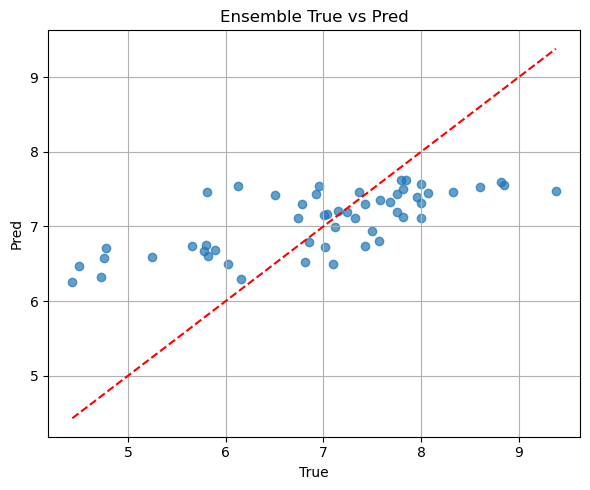

In [46]:


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
mae = mean_absolute_error(true_value, final_pred)
mse = mean_squared_error  (true_value, final_pred)
rmse= np.sqrt(mse)
r2  = r2_score           (true_value, final_pred)
print(f"Ensemble: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
plt.figure(figsize=(6,5)); plt.scatter(true_value,final_pred,alpha=0.7)
plt.plot([true_value.min(),true_value.max()],[true_value.min(),true_value.max()], 'r--'); plt.xlabel("True"); plt.ylabel("Pred"); plt.title("Ensemble True vs Pred"); plt.grid(True); plt.tight_layout(); plt.show()


# ## Step 8: Final Model Training on Combined Data & Test Evaluation


In [49]:
# %%
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# 1) Merge all train+val folds
all_data = []
for fold in range(10):
    all_data += torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    all_data += torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

# 2) Reserve a small val split for early stopping
tidx, vidx = train_test_split(
    list(range(len(all_data))),
    test_size=0.10,
    random_state=seed,
    shuffle=True
)
train_split = [all_data[i] for i in tidx]
val_split   = [all_data[i] for i in vidx]

train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_split,   batch_size=32)

# 3) Instantiate & train final model
model     = DeepGNNWithEdgeFeatures(input_dim, edge_dim,
                 hidden_channels=best_hidden_dim,
                 out_channels=out_channels,
                 dropout=best_dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, verbose=True
)

best_val_loss = float('inf')
patience      = 0

for epoch in range(1, 300):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = (F.cross_entropy(out, batch.y.long())
                if task == "classification"
                else F.mse_loss(out.squeeze(), batch.y))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation for early stopping
    preds, targets = evaluate(model, val_loader)
    val_loss = (F.cross_entropy(preds, targets.long()).item()
                if task == "classification"
                else F.mse_loss(preds.squeeze(), targets).item())

    scheduler.step(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience      = 0
        torch.save(model.state_dict(), os.path.join(results_dir, "final_model.pt"))
    else:
        patience += 1
        if patience >= 10:
            print("⏹️ Early stopping")
            break

# 4) Load best final model & evaluate on ORIGINAL TEST set
model.load_state_dict(torch.load(os.path.join(results_dir, "final_model.pt")))
test_data   = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

preds, targets = evaluate(model, test_loader)
pred_final     = (preds.argmax(dim=1).numpy() 
                  if task=="classification" 
                  else preds.squeeze().numpy())
true_final     = torch.cat([d.y for d in test_data]).numpy().astype(int if task=="classification" else float)

# 5) Compute final metrics
if task == "classification":
    from sklearn.metrics import (
        accuracy_score,
        precision_recall_fscore_support,
        roc_auc_score
    )
    acc       = accuracy_score(true_final, pred_final)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_final, pred_final, average="weighted", zero_division=0
    )
    probs     = F.softmax(preds, dim=1).cpu().numpy()
    auc       = roc_auc_score(
        label_binarize(true_final, classes=np.arange(num_classes)),
        probs, multi_class="ovr"
    )
    final_metrics = {
        "accuracy": acc, "precision": precision,
        "recall": recall, "f1_score": f1, "auc_roc": auc
    }
else:
    mae_f  = mean_absolute_error(true_final, pred_final)
    mse_f  = mean_squared_error(true_final, pred_final)
    rmse_f = np.sqrt(mse_f)
    r2_f   = r2_score(true_final, pred_final)
    final_metrics = {"mae": mae_f, "mse": mse_f, "rmse": rmse_f, "r2": r2_f}


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\1041781427.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data += torch.load(os.path.join(base_path, f"{task}_tra

Epoch 001 | Train Loss: 9.5025 | Val Loss: 1.2619
Epoch 002 | Train Loss: 2.0742 | Val Loss: 1.3099
Epoch 003 | Train Loss: 1.9896 | Val Loss: 1.2658
Epoch 004 | Train Loss: 1.8717 | Val Loss: 0.9991
Epoch 005 | Train Loss: 1.5141 | Val Loss: 1.0052
Epoch 006 | Train Loss: 1.4366 | Val Loss: 0.9485
Epoch 007 | Train Loss: 1.3707 | Val Loss: 0.8472
Epoch 008 | Train Loss: 1.2756 | Val Loss: 0.8791
Epoch 009 | Train Loss: 1.2537 | Val Loss: 1.1618
Epoch 010 | Train Loss: 1.1441 | Val Loss: 0.7036
Epoch 011 | Train Loss: 1.1182 | Val Loss: 0.7251
Epoch 012 | Train Loss: 1.0596 | Val Loss: 0.6749
Epoch 013 | Train Loss: 1.0476 | Val Loss: 0.6352
Epoch 014 | Train Loss: 0.9697 | Val Loss: 0.5917
Epoch 015 | Train Loss: 0.9631 | Val Loss: 0.6411
Epoch 016 | Train Loss: 0.9420 | Val Loss: 0.5043
Epoch 017 | Train Loss: 0.8643 | Val Loss: 0.4413
Epoch 018 | Train Loss: 0.8328 | Val Loss: 0.4855
Epoch 019 | Train Loss: 0.8065 | Val Loss: 0.4189
Epoch 020 | Train Loss: 0.7728 | Val Loss: 0.3724


C:\Users\johng23\AppData\Local\Temp\ipykernel_9476\1041781427.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(results_dir,

In [50]:
# Save final metrics to a CSV file
final_metrics_df = pd.DataFrame([final_metrics])
final_metrics_df.to_csv(os.path.join(results_dir, "final_metrics.csv"), index=False)

## 9: Final Model Training on Combined Train+Val & Test Evaluation (Hold‑Out Test)

,metric,ensemble,final
0,mae,0.720624,0.650439
1,mse,0.824372,0.779232
2,rmse,0.907950,0.882741
3,r2,0.379580,0.413552


✅ Final model saved to GraphSAGE_results/regression_10fold/final_model.pt
✅ Ensemble plot saved to GraphSAGE_results/regression_10fold/ensemble_plot.png
✅ Final model plot saved to GraphSAGE_results/regression_10fold/final_model_plot.png


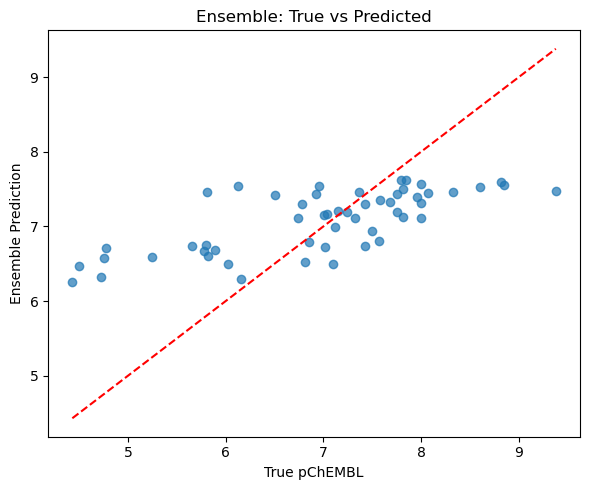

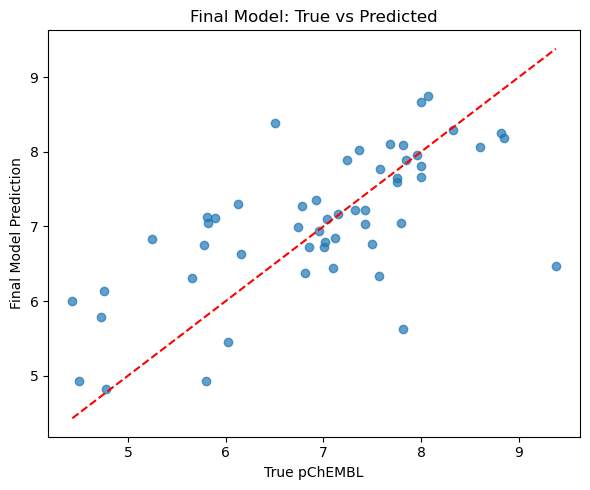

In [51]:
# Prepare ensemble metrics list
if task == "classification":
    ensemble_metrics = [acc, precision, recall, f1, auc]
else:
    ensemble_metrics = [mae, mse, rmse, r2]

# Create comparison DataFrame
comp = pd.DataFrame({
    "metric":   list(final_metrics.keys()),
    "ensemble": ensemble_metrics,
    "final":    list(final_metrics.values())
})
display(comp)


# 8) Save final model
model_path = os.path.join(results_dir, "final_model.pt")
torch.save(model.state_dict(), model_path)
print(f"✅ Final model saved to {model_path}")
#
ensemble_plot_path = os.path.join(results_dir, "ensemble_plot.png")
fig_ensemble, ax_ensemble = plt.subplots(figsize=(6, 5))
ax_ensemble.scatter(true_value, final_pred, alpha=0.7)
ax_ensemble.plot(
    [true_value.min(), true_value.max()],
    [true_value.min(), true_value.max()],
    'r--'
)
ax_ensemble.set_title("Ensemble: True vs Predicted")
ax_ensemble.set_xlabel("True pChEMBL")
ax_ensemble.set_ylabel("Ensemble Prediction")
plt.tight_layout()
fig_ensemble.savefig(ensemble_plot_path)
print(f"✅ Ensemble plot saved to {ensemble_plot_path}")

# Save final model plot
final_model_plot_path = os.path.join(results_dir, "final_model_plot.png")
fig_final, ax_final = plt.subplots(figsize=(6, 5))
ax_final.scatter(true_final, pred_final, alpha=0.7)
ax_final.plot(
    [true_final.min(), true_final.max()],
    [true_final.min(), true_final.max()],
    'r--'
)
ax_final.set_title("Final Model: True vs Predicted")
ax_final.set_xlabel("True pChEMBL")
ax_final.set_ylabel("Final Model Prediction")
plt.tight_layout()
fig_final.savefig(final_model_plot_path)
print(f"✅ Final model plot saved to {final_model_plot_path}")